In [47]:
#Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


In [48]:
torch.cuda.is_available()

True

In [49]:
torch.cuda.device_count()

1

In [50]:
#torch.cuda.current_device()

In [51]:
#torch.cuda.get_device_name(0)

In [52]:
#Set Parameters here
epochs = 80
batch_size = 100
train_points = 5000 # 60k total training examples, 10k test examples
test_points = 5000
lr = 0.01
weight_decay = 0.01
initialization_scale = 8.0
#Optmization steps should be train_points/batchsize * epochs 
print(train_points/batch_size * epochs)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


4000.0


In [53]:
def display_predictions(model, testloader, num_images=5):
    model.eval()
    # Randomly pick a batch of images from the testloader
    batch = random.choice(list(testloader))
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].to("cpu").numpy().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [54]:
#Network Structure
class mnistClassification(nn.Module):
    def __init__(self):
        super(mnistClassification, self).__init__()
        self.flatten = nn.Flatten().to(device)
        self.fc1 = nn.Linear(784, 200).to(device)
        self.fc2 = nn.Linear(200, 200).to(device)
        self.fc3 = nn.Linear(200, 10).to(device)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = mnistClassification().to(device)

with torch.no_grad(): 
    for p in model.parameters(): 
        p.data = initialization_scale * p.data

In [55]:
#Load Data set
train = torchvision.datasets.MNIST(root='mnistdata', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root='mnistdata', train=False, transform=torchvision.transforms.ToTensor(), download=True)
train = torch.utils.data.Subset(train, range(train_points))
test = torch.utils.data.Subset(test, range(test_points))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(test_loader))

50
50


Epoch [2/80], Loss: 0.5160, Train Accuracy: 0.1600, Val Accuracy: 0.1780, Weight Norm: 153.2845:   1%|▏         | 1/80 [00:02<01:59,  1.51s/it]

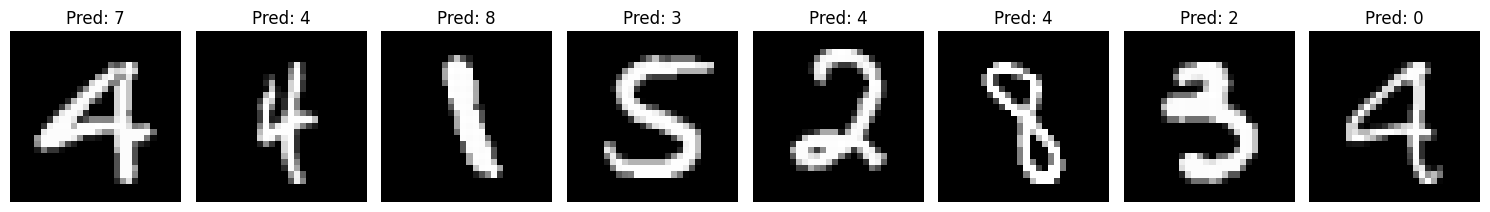

Epoch [10/80], Loss: 0.0845, Train Accuracy: 0.5200, Val Accuracy: 0.4530, Weight Norm: 147.0003:  11%|█▏        | 9/80 [00:13<01:28,  1.24s/it]

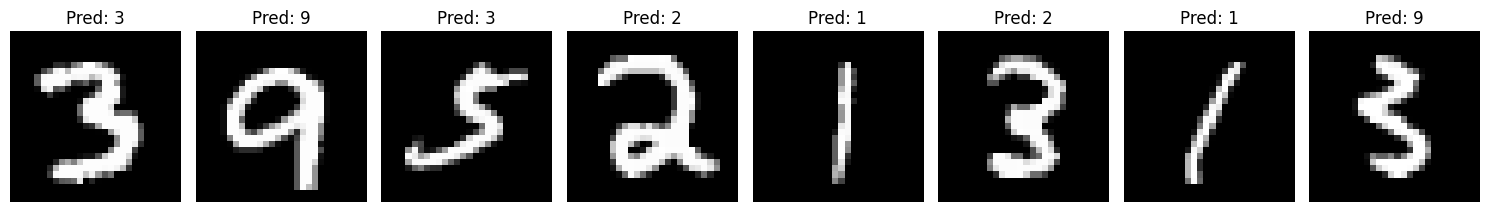

Epoch [20/80], Loss: 0.0492, Train Accuracy: 0.8000, Val Accuracy: 0.6740, Weight Norm: 139.9353:  24%|██▍       | 19/80 [00:26<01:15,  1.24s/it]

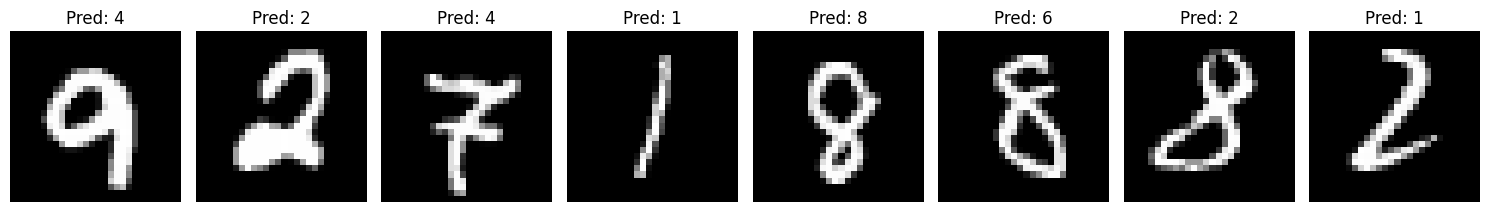

Epoch [27/80], Loss: 0.0438, Train Accuracy: 0.8400, Val Accuracy: 0.7396, Weight Norm: 135.3195:  34%|███▍      | 27/80 [00:35<01:10,  1.33s/it]

In [ ]:
#Training

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train_acc = []
val_acc = []
train_loss = []
weight_normlist = []

#Loop
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        labels_one_hot = F.one_hot(labels, 10).float()
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate Train Accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)
    
    # Store loss
    train_loss.append(loss.item())
    
    # Calculate Validation Accuracy
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for x, labels in test_loader:
            x = x.to(device)
            labels = labels.to(device)
            y = model(x)
            _, predicted = torch.max(y, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_acc.append(val_accuracy)

    # Calculate Weight Norm
    weight_norm = sum(p.norm().item() for p in model.parameters())
    weight_normlist.append(weight_norm)
    
    # Print progress
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Weight Norm: {weight_norm:.4f}')
    
    # Plot graph every X epochs
    if (epoch + 1) % 20 == 0 or epoch == 1:
        display_predictions(model, test_loader, num_images=8)
        
        '''
        import matplotlib.pyplot as plt
        plt.xscale("log")
        plt.plot(range(1, epoch + 2), train_acc, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()
        plt.show()
        '''

In [ ]:
#Evaluate
model.eval()
total = 0
correct = 0
one_hots = torch.eye(10, 10)
with torch.no_grad():
        for x, labels in test_loader:
            x = x.to(device)
            labels = labels.to(device)
            y = model(x)
            _, predicted = torch.max(y,1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)


print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 42.19%


Accuracy: 42.19%


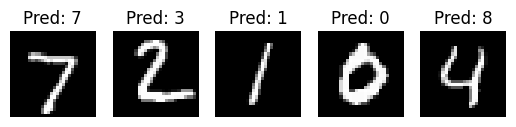

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
model.eval()
correct = 0
total = 0
one_hots = torch.eye(10, 10)

with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        labels = labels.to(device)
        y = model(x)
        _, predicted = torch.max(y, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f'Accuracy: {100 * accuracy:.2f}%')

# Display example predictions
display_predictions(model, test_loader, num_images=5)
